<a href="https://colab.research.google.com/github/sarenales/OFA-VSR/blob/main/Analisis_OFAVSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OFA

Preparación del modelo.

Se utilizará OFA-base.

In [ ]:
!git clone --single-branch --branch feature/add_transformers https://github.com/OFA-Sys/OFA

Cloning into 'OFA'...
remote: Enumerating objects: 5745, done.
remote: Counting objects: 100% (932/932), done.
remote: Compressing objects: 100% (256/256), done.
remote: Total 5745 (delta 710), reused 676 (delta 676), pack-reused 4813
Receiving objects: 100% (5745/5745), 97.78 MiB | 21.90 MiB/s, done.
Resolving deltas: 100% (2243/2243), done.
Updating files: 100% (3223/3223), done.


In [ ]:
!pip install OFA/transformers/

Processing ./OFA/transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 6.2 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.18.0.dev0-py3-none-any.whl size=3916748 sha256=7f31bd56f959b6fe9b7996c646d6094265a7e737a90fb1c8e78feaa5dfb2c5d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-9ocby96s/wheels/0b/bc/ea/00b6b8998c20c4fe55affe6062a2cddda80308ef9bd5d5877c
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.0
    Uninstalling transformers-4.41.0:
      Successfully uninstalled transformers-4.41.0


In [ ]:
!git lfs install
!git clone https://huggingface.co/OFA-Sys/OFA-base

Git LFS initialized.
Cloning into 'OFA-base'...
remote: Enumerating objects: 52, done.
remote: Total 52 (delta 0), reused 0 (delta 0), pack-reused 52 (from 1)
Unpacking objects: 100% (52/52), 541.04 KiB | 7.62 MiB/s, done.


In [ ]:
from transformers.models.ofa.generate import sequence_generator

In [ ]:
from transformers import OFATokenizer, OFAModel
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ofa_model = OFAModel.from_pretrained("./OFA-base", use_cache=False).to(device)
ofa_tokenizer = OFATokenizer.from_pretrained("./OFA-base")

/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


./OFA-base
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [ ]:
from PIL import Image
from torchvision import transforms
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 256

def load_image(image):
    patch_resize_transform = transforms.Compose([
            transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    patch_img = patch_resize_transform(image).unsqueeze(0).to(device)
    return patch_img

# DATASET

Comenzaremos obteniendo nuestras instancias del conjunto de datos VSR (Visual Scene Representation). A continuación, realizaremos un filtrado y adaptaremos los datos según nuestras necesidades para el proyecto en cuestión.

En el conjunto de datos original de VSR, cada instancia cuenta con diversos atributos, como "imagen", "link_imagen", "caption", etc. Nuestro primer paso será filtrar estas instancias y seleccionar únicamente aquellas que tengan la etiqueta (label) igual a 1. Posteriormente, nos quedaremos solamente con los atributos necesarios para nuestro análisis, descartando aquellos que no son relevantes. Además, añadiremos un par de atributos adicionales, como la relación opuesta a la que se describe en la leyenda original, junto con su respectiva descripción.

Nuestro dataset se guardará en la variable **filtro**.

In [ ]:
!git clone https://github.com/cambridgeltl/visual-spatial-reasoning.git

Cloning into 'visual-spatial-reasoning'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 253 (delta 37), reused 17 (delta 17), pack-reused 204
Receiving objects: 100% (253/253), 10.98 MiB | 12.36 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [ ]:
import json
archivo_jsonl = "/content/visual-spatial-reasoning/data/data_files/all_vsr_validated_data.jsonl"
train = []
with open(archivo_jsonl, "r") as f:
  for linea in f:
    objeto = json.loads(linea)
    train.append(objeto)

In [ ]:
diccionario_opuesto ={
    # Adjacency (10)
    "Adjacent to":"alongside",
    "alongside": "Adjacent to",
    "at the side of":"against",
    "at the right side of":"at the left side of",
    "at the left side of": "at the right side of",
    "attached to":"against",
    "at the back of":"ahead of",
    "ahead of":"at the back of",
    "against": "ahead of",
    "at the edge of":"Adjacent to",

  # Directional (16)
    "off":"up",
    "past":"across from",
    "toward":"down",
    "down":"up",
    "deep down":"up",
    "up":"deep down",
    "away from":"across from",
    "along":"Adjacent to",
    "around":"off",
    "from":"away from",
    "into":"off",
    "to":"in front of",
    "across":"off"  ,
    "across from":"Adjacent to" ,
    "through":"Adjacent to",
    "down from":"into"    ,

  # Orientation (4)
    "facing":"facing away from"  ,
    "facing away from":"facing"  ,
    "parallel to":"perpendicular to"  ,
    "perpendicular to":"parallel to"  ,

  # Projective (12)
    "on top of":"beneath"  ,
    "beneath":"on top of"  ,
    "beside":"far from"  ,
    "behind":"in front of"  ,
    "left of":"right of"  ,
    "right of":"left of"  ,
    "under":"over"  ,
    "in front of":"behind"  ,
    "below":"above"  ,
    "above":"below"  ,
    "over":"under"  ,
    "in the middle of": "above",

    # Proximity (6)
    "by":"far from"  ,
    "close to": "far from" ,
    "near":"far from"  ,
    "far from":"close to"  ,
    "far away from":"close to"  ,

    # Topological (18)
    "Connected to":"detached from"  ,
    "detached from":"part of"  ,
    "has as a part":"detached from"  ,
    "part of":"detached from"  ,
    "contains":"detached from"  ,
    "within":"out of"  ,
    "at":"out of"  ,
    "on":"out of"  ,
    "in":"out of"  ,
    "with":"out of"  ,
    "surrounding":"out of"  ,
    "among":"out of"  ,
    "consists of":"out of"  ,
    "out of":"between"  ,
    "between":"out to"  ,
    "inside":"outside"  ,
    "outside":"inside"  ,
    "touching": "detached from"  ,

    # Unallocated (6)
    "beyond":"enclosed by"  ,
    "next to":"beyond"  ,
    "opposite to":"Adjacent to"  ,
    "after":"among"  ,
    #"among":"after"  ,
    "enclosed by":"beyond"
}

In [ ]:
def obtener_contrario(palabra, diccionario):
  if palabra in diccionario:
    return diccionario[palabra]
  else:
    return "Palabra no encontrada"

In [ ]:
def saber_split(url):
  if 'train' in url:
    return "train"
  else:
    return "dev"

In [ ]:
filtro = {}
cont = 0

for elemento in train:
  if elemento.get("label") == 1:

    nuevo_elemento = {
        "image" : elemento.get("image"),
        "image_link": elemento.get("image_link"),
        "caption+" : elemento.get("caption"),
        "caption-" :  elemento.get("caption").replace(elemento.get("relation"),  obtener_contrario(elemento.get("relation"), diccionario_opuesto)),
        "relation+" : elemento.get("relation"),
        "relation-" : obtener_contrario(elemento.get("relation"), diccionario_opuesto),
        "split": saber_split(elemento.get("image_link"))
    }

    filtro[cont] = nuevo_elemento
    cont +=1

with open("filtrado.json", "w") as archivo:
  json.dump(filtro, archivo)


print(f"Nuevo JSON creado exitosamente con los elementos filtrados. Número de elementos {cont}.")

Nuevo JSON creado exitosamente con los elementos filtrados. Número de elementos 5621.


In [ ]:
len(train)

10972

# Objetivo
Vamos a evaluar nuestro conjunto de datos en el framework de aprendizaje automático OFA (One-for-All). Queremos que OFA pueda entender si el caption corresponde a una imagen específica. Para lograr eso, para cada imagen que disponemos, introduciremos tanto la imagen real como su descripción correspondiente, que incluye una relación espacial que describe adecuadamente la imagen. El modelo debería decirnos "yes" si el caption coincide correctamente con la imagen.

Para asegurarnos de que el modelo realmente comprende la relación entre la imagen y el caption, repetiremos este proceso, pero esta vez introduciremos una descripción que no corresponde realmente a la imagen. Esta vez, usamos la misma imagen pero con un caption diferente que no describe la imagen correctamente. En este caso, el modelo debería decirnos "no".


Durante los análisis, registraremos el número de Verdaderos Positivos (TP), Falsos Negativos (FN), Verdaderos Negativos (TN) y Falsos Positivos (FP), con el fin de construir posteriormente una matriz de confusión. No obstante el accuracy y número de aciertos en función por su relación y tipo de relación espacial.

Luego, procederemos a graficar el porcentaje de las relaciones que han sido clasificadas como TP, FN, etc., con el objetivo de identificar patrones y tendencias en el rendimiento del modelo. Además de ver cuáles son las relaciones que más difícil son de identificar para el modelo.

# Extracción de características (Evaluaciones 1 - 2)

Aquí solamente almacenaremos los datos necesarios probados por el modelo.

Por cada instancia vamos a almacenar las probabilidades de salir la **primera palabra** yes/no con el caption positivo y con el caption negativo. Para ello se comprueba que la primera palabra es yes/no. En caso de que no sea la probabilidad la marcamos como 0.0%. Además, almacenamos también los captions que OFA nos devuelve.

Tiempo de análisis aproximado: **5h 30min**

In [ ]:
import json
import torch
import numpy as np
import time
import requests
from io import BytesIO
from torch import nn

In [ ]:
def token_imag(url):
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  patch_img = load_image(image.convert("RGB"))
  return patch_img, image

In [ ]:
def token_cap(caption):
  cap = "Does the image describe the following sentence?  " + caption
  text = ofa_tokenizer([cap], padding=True, truncation=True, return_tensors="pt").to(device).input_ids
  return text

In [ ]:
def input_model(caption, patch_img):
  gen_output_0 = ofa_model.generate(caption, patch_images=patch_img,num_beams=1, no_repeat_ngram_size=1,  return_dict_in_generate=True , output_scores=True )
  ofa_caption_0 = ofa_tokenizer.batch_decode(gen_output_0[0], skip_special_tokens=True)[0].strip()
  return ofa_caption_0, gen_output_0

In [ ]:
with open("filtrado.json", "r") as f:
    datos = json.load(f)

In [ ]:
def comprobar_primera_p(ofa_caption_0):
    palabras = ofa_caption_0.split()
    yn = ["yes", "no","yes,","no,","yes.","no.","yes..", "no..", "yes!","no!", "yes...","no..."]
    if not palabras:
        return False
    elif palabras[0].lower() in yn:
      return True
    return False

def comprobar_primera_yes(ofa_caption_0):
  palabras = ofa_caption_0.split()
  if not palabras:
    return False
  elif palabras[0].lower() == "yes":
    return True
  return False

In [ ]:
mean_probP

In [ ]:
def get_probabilidades(gen_output_0):
  probabilities = nn.functional.softmax(gen_output_0[1][0], dim=-1)
  probYES = probabilities[0][tokens.get("Ġyes")].item()
  probNO = probabilities[0][tokens.get("Ġno")].item()
  return probYES, probNO

In [ ]:
resultados = {}
tokens = ofa_tokenizer.get_vocab()

cont = 0

for indice, (clave,valor) in enumerate(datos.items()):
  probYESP = 0.0
  probNOP = 0.0
  probYESN = 0.0
  probNON = 0.0
  respP = ""
  respN = ""

  url = valor["image_link"]
  patch_img = token_imag(url)[0]

  caption = token_cap(valor["caption+"])
  ofa_caption_0, gen_output_0 = input_model(caption, patch_img)
  respP = ofa_caption_0

  if comprobar_primera_p(ofa_caption_0):
    probYESP, probNOP = get_probabilidades(gen_output_0)

    caption = token_cap(valor["caption-"])
    ofa_caption_0, gen_output_0 = input_model(caption, patch_img)
    respN = ofa_caption_0
    if comprobar_primera_p(ofa_caption_0):
      probYESN, probNON = get_probabilidades(gen_output_0)

  valor["PY+"] = probYESP
  valor["PN+"] = probNOP
  valor["response+"] = respP
  valor["PY-"] = probYESN
  valor["PN-"] = probNON
  valor["response-"] = respN
  resultados[cont] = valor
  cont += 1

with open("resultados1.json", "w") as archivo:
  json.dump(resultados, archivo)

# **Evaluación 1**: ITM (Image Text Matching)

En esta primera fase de evaluación, nos enfocaremos únicamente en el resultado de la predicción y realizaremos un análisis de los resultados obtenidos.

## Analisis ITM (Image Text Matching)

In [ ]:
import json

with open("resultados1.json", "r") as resultados_json:
    datos_ITM = json.load(resultados_json)

In [ ]:
def convert_response_to_label(response):
  palabras = response.split()
  if not palabras:
    return -1
  y = ["yes", "yes,","yes.","yes..",  "yes!","yes..."]
  n = [ "no","no,","no.", "no..", "no!", "no..."]
  if palabras[0].lower() in y :
      return 1
  elif palabras[0].lower() in n:
      return 0
  else:
      return -1

In [ ]:
y_pred = []
y_true = []
predicciones_correctas_solo_yes = 0
predicciones_correctas_solo_yesNo = 0

for indice, (clave,valor) in enumerate(datos.items()):
  acierto_yes = convert_response_to_label(valor["response+"])
  y_pred.append(acierto_yes)
  y_true.append(1)
  acierto_no = convert_response_to_label(valor["response-"])
  y_pred.append(acierto_no)
  y_true.append(0)
  if acierto_yes == 1:
    predicciones_correctas_solo_yes += 1
    if acierto_no == 0:
      predicciones_correctas_solo_yesNo += 1

total_predicciones = len(datos)
accuracy_yes = predicciones_correctas_solo_yes / total_predicciones
accuracy_yesNo = predicciones_correctas_solo_yesNo / total_predicciones

print("Número de predicciones correctas cap1-Yes:               ", predicciones_correctas_solo_yes)
print("Número de predicciones correctas cap1-Yes & cap2-No:     ", predicciones_correctas_solo_yesNo)
print("Total de predicciones:                                   ", total_predicciones)
print("--------------------------------------------------------------------------------")
print("Accuracy yes:                                             ", accuracy_yes)
print("Accuracy yes&no:                                          ", accuracy_yesNo)

Número de predicciones correctas cap1-Yes:                4791
Número de predicciones correctas cap1-Yes & cap2-No:      207
Total de predicciones:                                    5621
--------------------------------------------------------------------------------
Accuracy yes:                                              0.8523394413805373
Accuracy yes&no:                                           0.03682618751111902


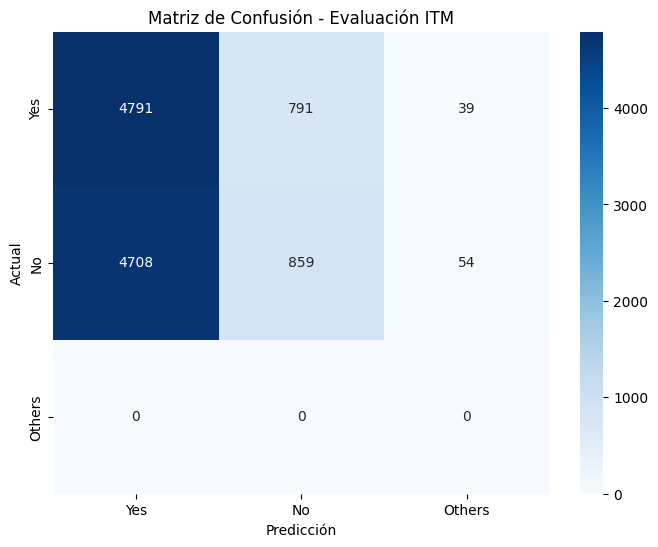

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


conf_matrix = confusion_matrix(y_true, y_pred, labels=[1, 0, -1])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Yes', 'No', 'Others'], yticklabels=['Yes', 'No', 'Others'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Evaluación ITM')
plt.show()


# **Evaluación 2**: Probabilidades (Logits)

El objetivo aquí es contrastar con los dos inputs diferentes por cada imagen, caption positivo y caption negativo, ver si el modelo es capaz de elegir el caption correcto (el positivo).

Para ello nos fijaremos en los logits (probabilidades) que saca el modelo. Constrastaremos la probabilidad del caption positivo y negativo.


## Análisis 1: Probabilidades

In [ ]:
import json

with open("resultados1.json", "r") as resultados_json:
    datos = json.load(resultados_json)

In [ ]:
def acierta_1(PYP,PNP,PYN,PNN):
  DP = abs(PYP - PNP)
  DN = abs(PYN - PNN)

  if DN == 0.0:
    return 0
  if DP == 0.0:
    return 0

  if DP > DN :
    return 1
  return 0

In [ ]:
datos_filtrados = []

for indice, (clave,valor) in enumerate(datos.items()):
  rel_esp = valor["relation+"]
  acierto = acierta_1(valor["PY+"],valor["PN+"],valor["PY-"],valor["PN-"])
  datos_filtrados.append({"relacion_espacial": rel_esp, "acierto": acierto})

In [ ]:
predicciones_correctas = sum(1 for instancia in datos_filtrados if instancia["acierto"] == 1)

total_predicciones = len(datos_filtrados)

accuracy = predicciones_correctas / total_predicciones

print("Número de predicciones correctas:  ", predicciones_correctas)
print("Total de predicciones:             ", total_predicciones)
print("------------------------------------------------------")
print("Accuracy:                          ", accuracy)

Número de predicciones correctas:   3042
Total de predicciones:              5621
------------------------------------------------------
Accuracy:                           0.5411848425547056


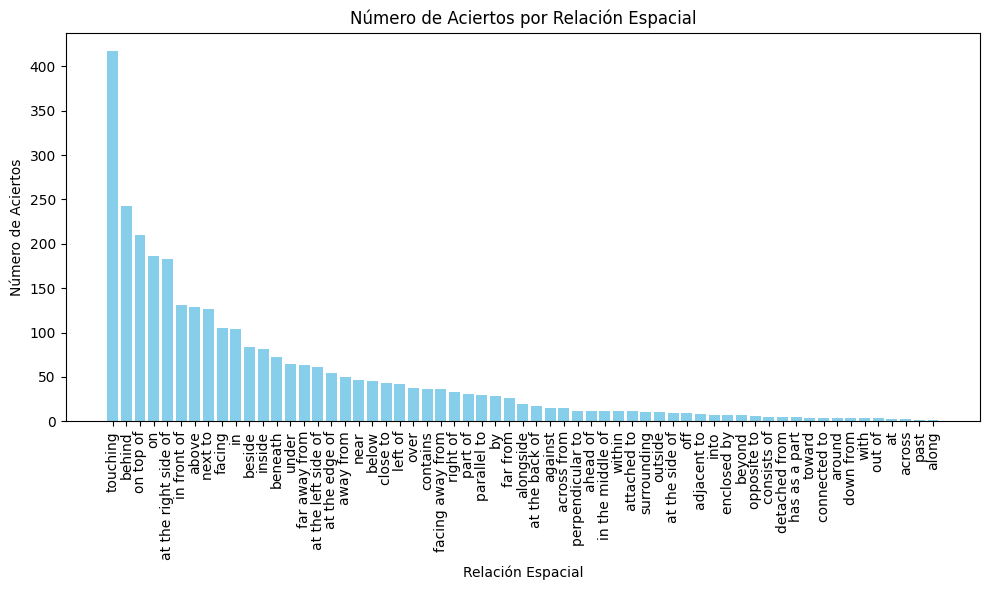

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.DataFrame(datos_filtrados)
aciertos_por_relacion = df[df['acierto'] == 1].groupby('relacion_espacial').size()
aciertos_por_relacion = aciertos_por_relacion.reset_index(name='numero_aciertos')
aciertos_por_relacion = aciertos_por_relacion.sort_values(by='numero_aciertos', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(aciertos_por_relacion['relacion_espacial'], aciertos_por_relacion['numero_aciertos'], color='skyblue')
plt.xlabel('Relación Espacial')
plt.ylabel('Número de Aciertos')
plt.title('Número de Aciertos por Relación Espacial')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


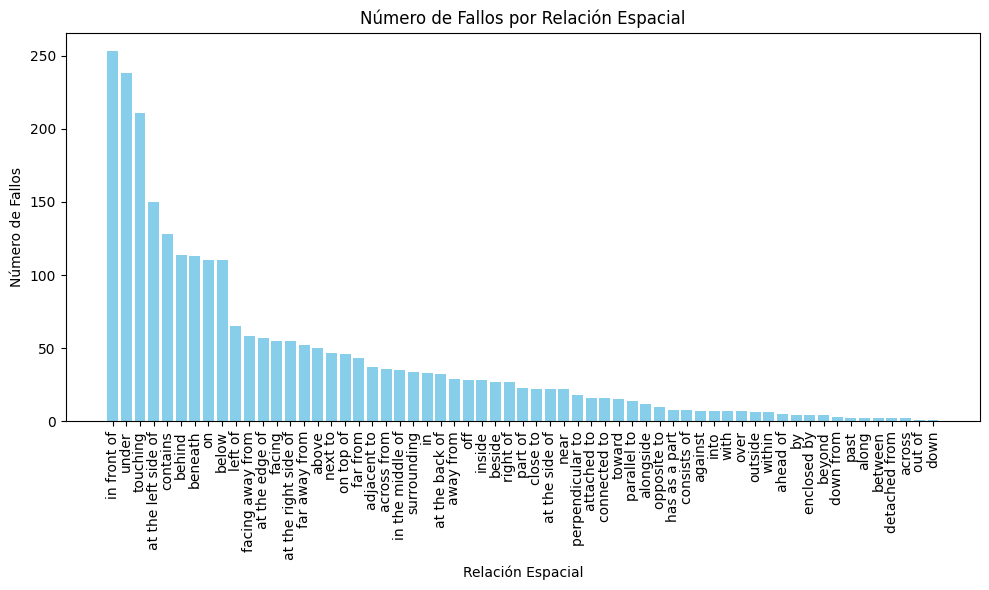

In [ ]:
df = pd.DataFrame(datos_filtrados)

fallos_por_relacion = df[df['acierto'] == 0].groupby('relacion_espacial').size()
fallos_por_relacion = fallos_por_relacion.reset_index(name='numero_fallos')
fallos_por_relacion = fallos_por_relacion.sort_values(by='numero_fallos', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(fallos_por_relacion['relacion_espacial'], fallos_por_relacion['numero_fallos'], color='skyblue')
plt.xlabel('Relación Espacial')
plt.ylabel('Número de Fallos')
plt.title('Número de Fallos por Relación Espacial')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
categories = {
    "Adjacency": [
        "adjacent to", "alongside", "at the side of", "at the right side of",
        "at the left side of", "attached to", "at the back of", "ahead of",
        "against", "at the edge of"
    ],
    "Directional": [
        "off", "past", "toward", "down", "deep down", "up", "away from",
        "along", "around", "from", "into", "to", "across", "across from",
        "through", "down from"
    ],
    "Orientation": [
        "facing", "facing away from", "parallel to", "perpendicular to"
    ],
    "Projective": [
        "on top of", "beneath", "beside", "behind", "left of", "right of",
        "under", "in front of", "below", "above", "over", "in the middle of"
    ],
    "Proximity": [
        "by", "close to", "near", "far from", "far away from"
    ],
    "Topological": [
        "connected to", "detached from", "has as a part", "part of", "contains",
        "within", "at", "on", "in", "with", "surrounding", "among",
        "consists of", "out of", "between", "inside", "outside", "touching"
    ],
    "Unallocated": [
        "beyond", "next to", "opposite to", "after", "among", "enclosed by"
    ]
}

In [ ]:
def categorize_relation(relation):
    for category, relations in categories.items():
        if relation in relations:
            return category
    return "Unknown"

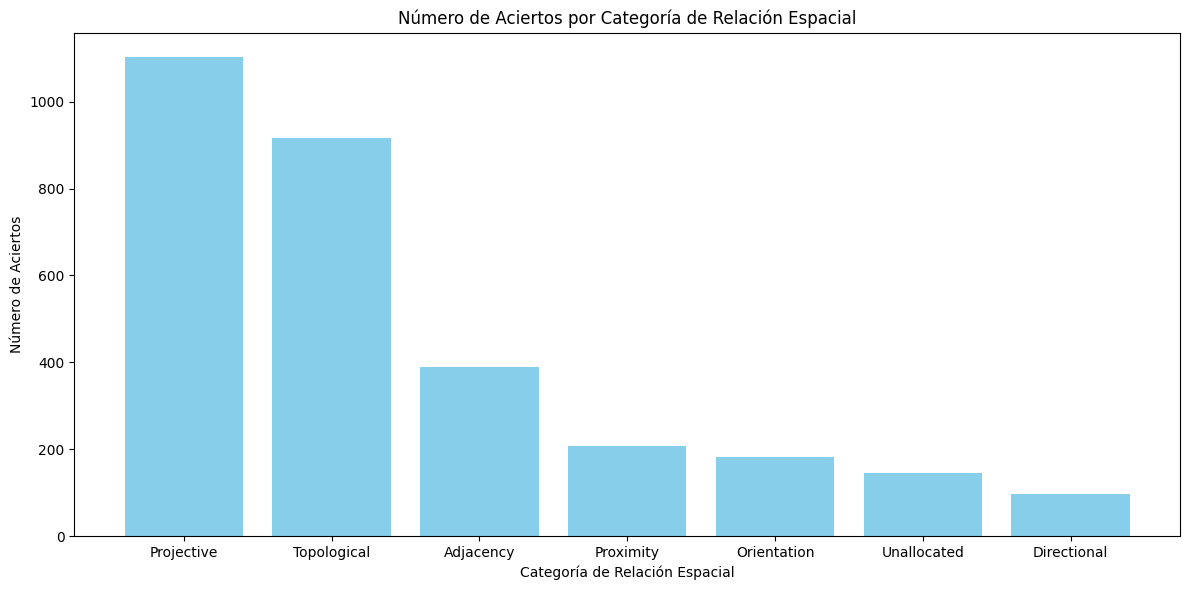

In [ ]:
df = pd.DataFrame(datos_filtrados)

df['categoria'] = df['relacion_espacial'].apply(categorize_relation)

aciertos_por_categoria = df[df['acierto'] == 1].groupby('categoria').size()
aciertos_por_categoria = aciertos_por_categoria.reset_index(name='numero_aciertos')
aciertos_por_categoria = aciertos_por_categoria.sort_values(by='numero_aciertos', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(aciertos_por_categoria['categoria'], aciertos_por_categoria['numero_aciertos'], color='skyblue')
plt.xlabel('Categoría de Relación Espacial')
plt.ylabel('Número de Aciertos')
plt.title('Número de Aciertos por Categoría de Relación Espacial')


plt.tight_layout()
plt.show()

## Análisis 2: Criterio probabilidades normalizadas

In [ ]:
def acierta_2(PYP,PNP,PYN,PNN):
  if PYP == 0.0:
    return 0
  if PYN == 0.0:
    return 0

  total_prob_p = PYP + PNP
  normalized_prob_yes_p = PYP / total_prob_p
  normalized_prob_no_p = PNP / total_prob_p

  total_prob_n = PYN + PNN
  normalized_prob_yes_n = PYN / total_prob_n
  normalized_prob_no_n = PNN / total_prob_n

  if normalized_prob_yes_p > normalized_prob_no_n:
    return 1
  return 0


In [ ]:
datos_filtrados = []

for indice, (clave,valor) in enumerate(datos.items()):
  rel_esp = valor["relation+"]
  acierto = acierta_2(valor["PY+"],valor["PN+"],valor["PY-"],valor["PN-"])
  datos_filtrados.append({"relacion_espacial": rel_esp, "acierto": acierto})

In [ ]:
predicciones_correctas = sum(1 for instancia in datos_filtrados if instancia["acierto"] == 1)

total_predicciones = len(datos_filtrados)

accuracy = predicciones_correctas / total_predicciones

print("Número de predicciones correctas:  ", predicciones_correctas)
print("Total de predicciones:             ", total_predicciones)
print("------------------------------------------------------")
print("Accuracy:                          ", accuracy)

Número de predicciones correctas:   4780
Total de predicciones:              5621
------------------------------------------------------
Accuracy:                           0.8503824942181106


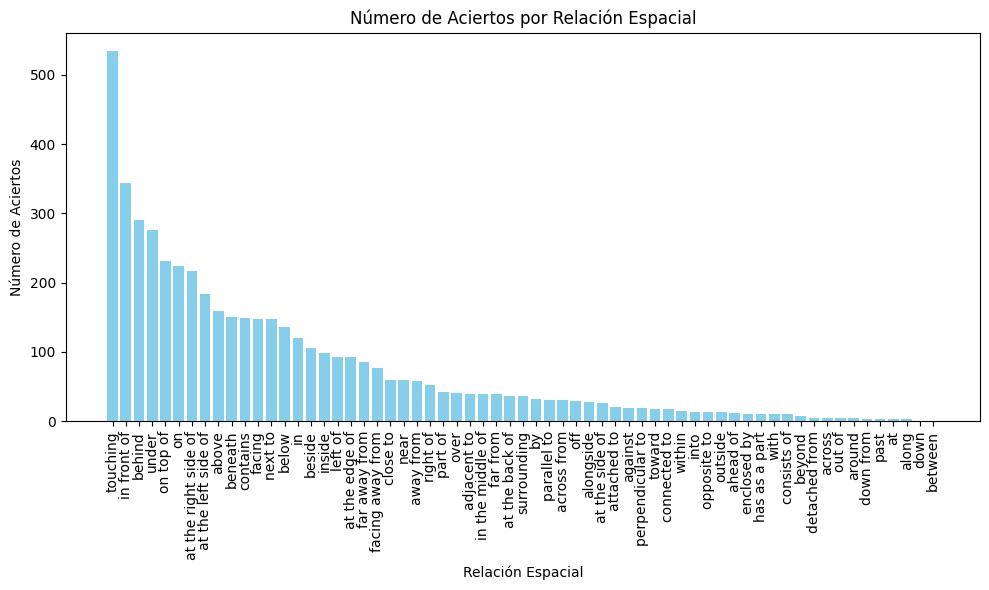

In [ ]:
df = pd.DataFrame(datos_filtrados)
aciertos_por_relacion = df[df['acierto'] == 1].groupby('relacion_espacial').size()
aciertos_por_relacion = aciertos_por_relacion.reset_index(name='numero_aciertos')
aciertos_por_relacion = aciertos_por_relacion.sort_values(by='numero_aciertos', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(aciertos_por_relacion['relacion_espacial'], aciertos_por_relacion['numero_aciertos'], color='skyblue')
plt.xlabel('Relación Espacial')
plt.ylabel('Número de Aciertos')
plt.title('Número de Aciertos por Relación Espacial')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


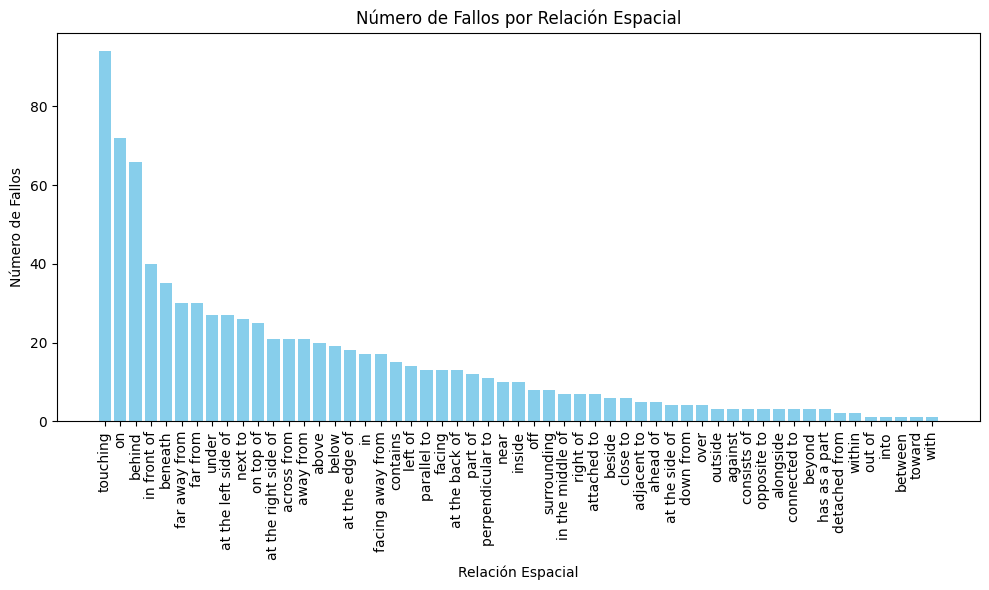

In [ ]:
df = pd.DataFrame(datos_filtrados)

fallos_por_relacion = df[df['acierto'] == 0].groupby('relacion_espacial').size()
fallos_por_relacion = fallos_por_relacion.reset_index(name='numero_fallos')
fallos_por_relacion = fallos_por_relacion.sort_values(by='numero_fallos', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(fallos_por_relacion['relacion_espacial'], fallos_por_relacion['numero_fallos'], color='skyblue')
plt.xlabel('Relación Espacial')
plt.ylabel('Número de Fallos')
plt.title('Número de Fallos por Relación Espacial')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

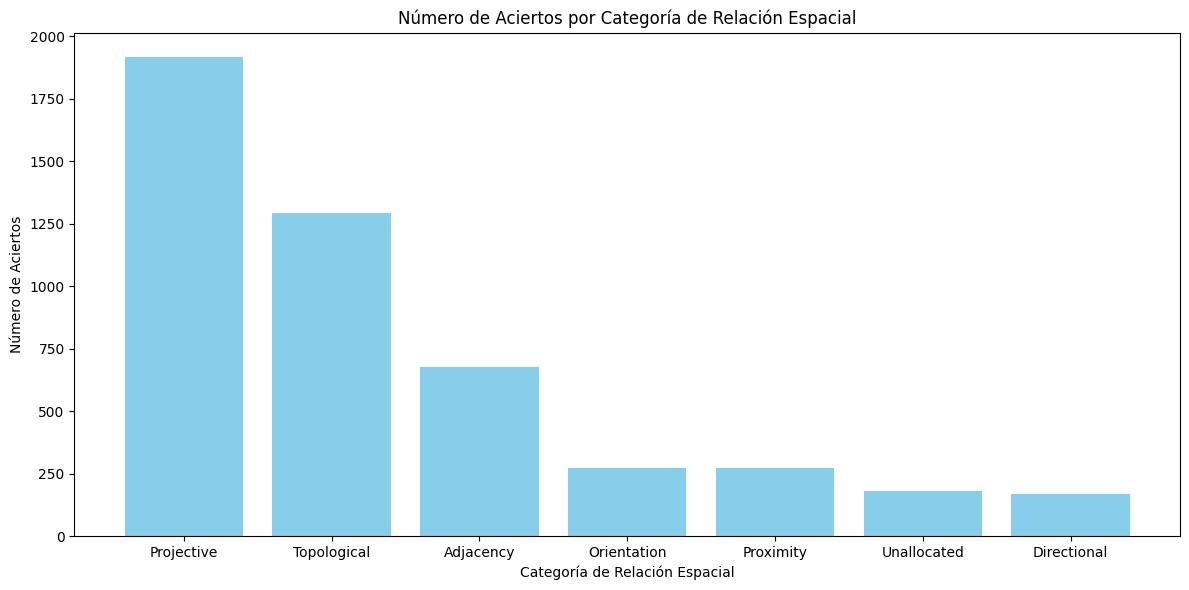

In [ ]:
df = pd.DataFrame(datos_filtrados)

df['categoria'] = df['relacion_espacial'].apply(categorize_relation)

aciertos_por_categoria = df[df['acierto'] == 1].groupby('categoria').size()
aciertos_por_categoria = aciertos_por_categoria.reset_index(name='numero_aciertos')
aciertos_por_categoria = aciertos_por_categoria.sort_values(by='numero_aciertos', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(aciertos_por_categoria['categoria'], aciertos_por_categoria['numero_aciertos'], color='skyblue')
plt.xlabel('Categoría de Relación Espacial')
plt.ylabel('Número de Aciertos')
plt.title('Número de Aciertos por Categoría de Relación Espacial')


plt.tight_layout()
plt.show()

## Más análisis de los datos extraídos - Matriz confusión

In [ ]:
TP = 0
FN = 0
TN = 0
FP = 0
R = 0

In [ ]:
def analisis_TP_FN(probYES, probNO):
  global TP
  global FN
  global R
  if probYES > probNO:
    TP += 1
  elif probYES < probNO:
    FN += 1
  else:
    R += 1

def analisis_TN_FP(probYES, probNO):
  global FP
  global TN
  global R
  if probNO > probYES:
    TN += 1
  elif probNO < probYES:
    FP += 1
  else:
    R += 1

In [ ]:
for indice, (clave,valor) in enumerate(datos.items()):
  analisis_TP_FN(valor["PY+"], valor["PN+"])

  analisis_TN_FP(valor["PY-"], valor["PN-"])

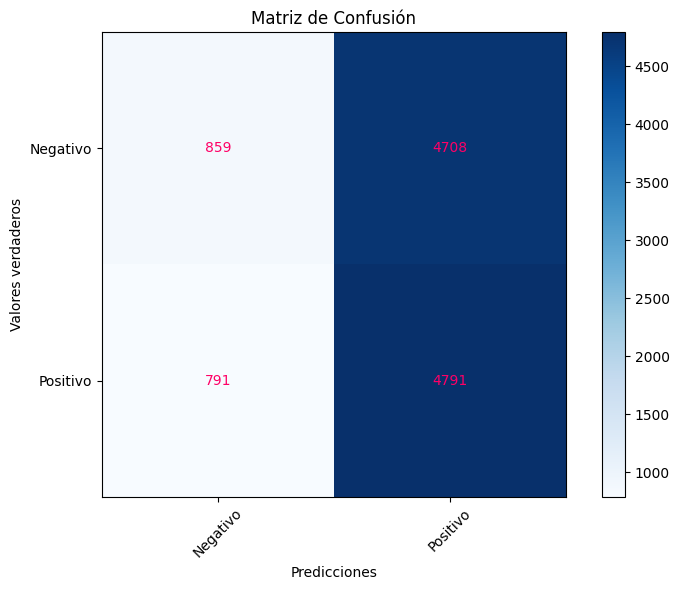

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

matriz_confusion = np.array([[TN, FP], [FN, TP]])
etiquetas = ['Negativo', 'Positivo']


plt.figure(figsize=(8, 6))
plt.imshow(matriz_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()


ticks = np.arange(len(etiquetas))
plt.xticks(ticks, etiquetas, rotation=45)
plt.yticks(ticks, etiquetas)


for i in range(len(etiquetas)):
    for j in range(len(etiquetas)):
        plt.text(j, i, matriz_confusion[i, j], ha='center', va='center', color='#ff0066')

plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.tight_layout()
plt.show()

# Evaluación 3: Captioner

In [ ]:
import json
import torch
import numpy as np
import time
import requests
from io import BytesIO
from torch import nn
import math
from tabulate import tabulate

In [ ]:
def token_imag(url):
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  patch_img = load_image(image.convert("RGB"))
  return patch_img, image

In [ ]:
def token_cap(caption):
  text = ofa_tokenizer([caption], padding=True, truncation=True, return_tensors="pt").to(device).input_ids
  return text

In [ ]:
def input_model(inputs, patch_img,decoder_input):
  gen_output_0 = ofa_model.generate(inputs, patch_images=patch_img,decoder_input_id = decoder_input, num_beams=1, no_repeat_ngram_size=1,  return_dict_in_generate=True , output_scores=True)
  ofa_caption_0 = ofa_tokenizer.batch_decode(gen_output_0[0], skip_special_tokens=False)
  return ofa_caption_0, gen_output_0

In [ ]:
import json
with open("filtrado.json", "r") as f:
    datos = json.load(f)

In [ ]:
def probability_to_logit(p):
    p = p.item()
    if p <= 0 or p >= 1:
        return 0
    return np.log(p / (1 - p))

In [ ]:
def partes(caption):
  partes = caption.split()
  palabras = []
  for parte in partes:
    palabras.extend(parte.split("."))
  palabras[-1] = "."
  palabras.append("</s>")
  return palabras

In [ ]:
import math
def pro_logs(logits_output, tokens, palabras):
  sum_pro = 0
  mul_pro = 0
  suma_log1 = 0
  suma_log2 = 0

  for tensor, p in zip(logits_output[0][0], palabras):
    pos_p = tokens.get(p)
    probabilities = nn.functional.softmax(tensor, dim=-1)
    if pos_p is None:
      log_1 = 0.0
      prob = 0.0
      log_2 = 0.0
    else:
      log_1 = tensor[pos_p].item()
      prob = probabilities[pos_p]
      log_2 = probability_to_logit(prob)
    suma_log1 += log_1
    sum_pro += prob
    mul_pro *= prob
    suma_log2 += log_2
  return  sum_pro.item(), mul_pro.item() ,suma_log1 ,suma_log2

In [ ]:
resultados_captioner = {}

txt = "what does the image describe?"
inputs = token_cap(txt)
tokens = ofa_tokenizer.get_vocab()
cont = 0

for indice, (clave,valor) in enumerate(datos.items()):
  url = valor["image_link"]
  patch_img = token_imag(url)[0]

  decoder_input_P = token_cap(valor["caption+"])
  logits_output_P = ofa_model.forward(input_ids=inputs,patch_images=patch_img, decoder_input_ids=decoder_input_P)
  palabrasP = partes(valor["caption+"])
  sum_pro_P, mul_pro_P ,suma_log1_P ,suma_log2_P = pro_logs(logits_output_P, tokens, palabrasP)
  valor["mul_prob+"] = mul_pro_P
  valor["suma_log1+"] = suma_log1_P
  valor["suma_log2+"] = suma_log2_P
  valor["prob_media+"] = sum_pro_P/len(palabrasP)

  decoder_input_N = token_cap(valor["caption-"])
  logits_output_N = ofa_model.forward(input_ids=inputs,patch_images=patch_img, decoder_input_ids=decoder_input_N)
  palabrasN = partes(valor["caption+"])
  sum_pro_N, mul_pro_N ,suma_log1_N ,suma_log2_N = pro_logs(logits_output_N, tokens, palabrasN)
  valor["mul_prob-"] = mul_pro_N
  valor["suma_log1-"] = suma_log1_N
  valor["suma_log2-"] = suma_log2_N
  valor["prob_media-"] = sum_pro_N/len(palabrasN)


  resultados_captioner[cont] = valor
  cont += 1


with open("resultados_captioner.json", "w") as archivo:
  json.dump(resultados_captioner, archivo)

In [ ]:
resultados_captioner

{0: {'image': '000000224670.jpg',
  'image_link': 'http://images.cocodataset.org/train2017/000000224670.jpg',
  'caption+': 'The train contains the laptop.',
  'caption-': 'The train detached from the laptop.',
  'relation+': 'contains',
  'relation-': 'detached from',
  'split': 'train',
  'mul_prob+': 0.0,
  'suma_log1+': 4.111243724822998,
  'suma_log2+': -68.30938145108477,
  'prob_media+': 0.08795139619282313,
  'mul_prob-': 0.0,
  'suma_log1-': -6.493558645248413,
  'suma_log2-': -81.26205207568273,
  'prob_media-': 0.002291776772056307},
 1: {'image': '000000266622.jpg',
  'image_link': 'http://images.cocodataset.org/train2017/000000266622.jpg',
  'caption+': 'The bowl is at the left side of the banana.',
  'caption-': 'The bowl is at the right side of the banana.',
  'relation+': 'at the left side of',
  'relation-': 'at the right side of',
  'split': 'train',
  'mul_prob+': 0.0,
  'suma_log1+': 30.422306418418884,
  'suma_log2+': -136.81213916454195,
  'prob_media+': 0.1014814

In [3]:
import json

with open("resultados_captioner.json", "r") as resultados_json:
    datos = json.load(resultados_json)

In [27]:
def diferencia_PN(p,n):
  return abs(p-n)

In [4]:
def acierta(positivo, negativo):
  if positivo > negativo:
    return 1
  return 0

In [39]:
datos_filtrados_log = []
datos_filtrados_prob = []
datos_filtrados_prob_D = []

for indice, (clave,valor) in enumerate(datos.items()):
  rel_esp = valor["relation+"]
  sum_logP = valor["suma_log1+"]
  sum_logN = valor["suma_log1-"]

  prob_mediaP = valor["prob_media+"]
  prob_mediaN = valor["prob_media-"]

  acierto_log = acierta(sum_logP,sum_logN)

  acierto_prob = acierta(prob_mediaP,prob_mediaN)
  datos_filtrados_log.append({"relacionE": rel_esp, "acierto_log": acierto_log,"sum_logP":sum_logP, "sum_logN":sum_logN  })
  datos_filtrados_prob.append({"relacionE": rel_esp, "acierto_prob": acierto_prob, "mean_probP":prob_mediaP, "mean_probN":prob_mediaN })
  datos_filtrados_prob_D.append({"relacionE": rel_esp, "acierto_prob": acierto_prob, "dif_prob":diferencia_PN(prob_mediaP,prob_mediaN)})

In [6]:
predicciones_correctas = sum(1 for instancia in datos_filtrados_log if instancia["acierto_log"] == 1)

total_predicciones = len(datos_filtrados_log)

accuracy = predicciones_correctas / total_predicciones

print("Número de predicciones correctas:  ", predicciones_correctas)
print("Total de predicciones:             ", total_predicciones)
print("------------------------------------------------------")
print("Accuracy LOGITS:                   ", accuracy)

Número de predicciones correctas:   4735
Total de predicciones:              5621
------------------------------------------------------
Accuracy LOGITS:                    0.8423768012809109


In [7]:
predicciones_correctas = sum(1 for instancia in datos_filtrados_prob if instancia["acierto_prob"] == 1)

total_predicciones = len(datos_filtrados_prob)

accuracy = predicciones_correctas / total_predicciones

print("Número de predicciones correctas:  ", predicciones_correctas)
print("Total de predicciones:             ", total_predicciones)
print("------------------------------------------------------")
print("Accuracy PROB. MEDIA:              ", accuracy)

Número de predicciones correctas:   4429
Total de predicciones:              5621
------------------------------------------------------
Accuracy PROB. MEDIA:               0.7879380893079523


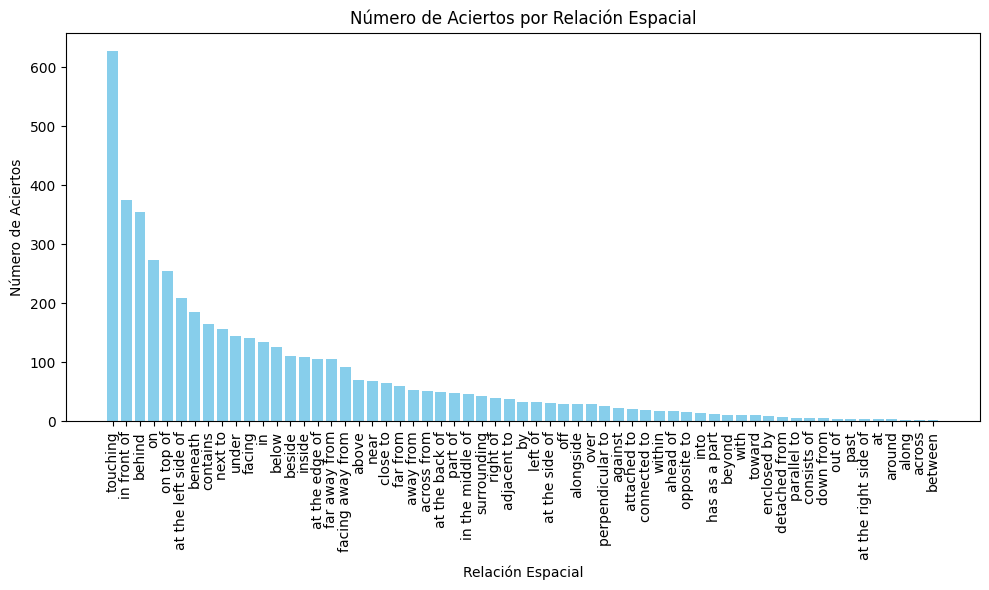

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(datos_filtrados_log)
aciertos_por_relacion = df[df['acierto_log'] == 1].groupby('relacionE').size()
aciertos_por_relacion = aciertos_por_relacion.reset_index(name='numero_aciertos')
aciertos_por_relacion = aciertos_por_relacion.sort_values(by='numero_aciertos', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(aciertos_por_relacion['relacionE'], aciertos_por_relacion['numero_aciertos'], color='skyblue')
plt.xlabel('Relación Espacial')
plt.ylabel('Número de Aciertos')
plt.title('Número de Aciertos por Relación Espacial')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

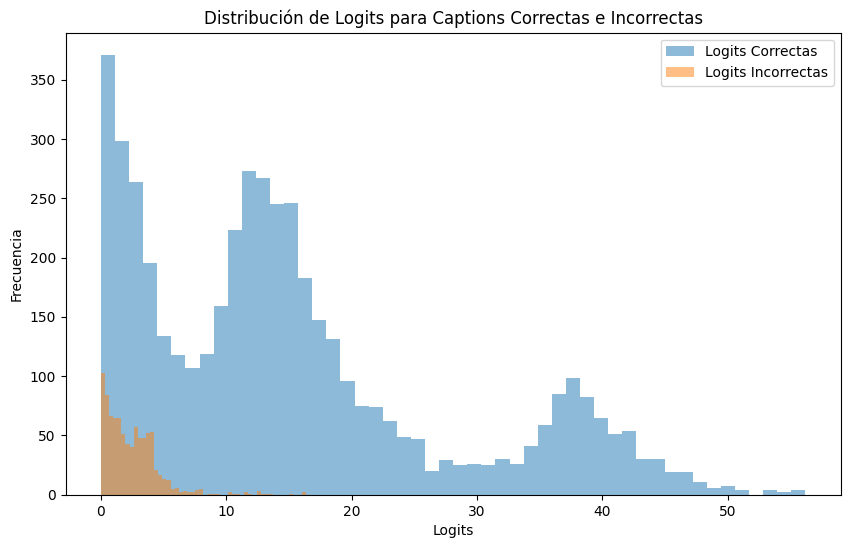

In [28]:

correct_probs = [diferencia_PN(item['sum_logP'],item['sum_logN']) for item in datos_filtrados_log if item['acierto_log'] == 1]
incorrect_probs = [diferencia_PN(item['sum_logP'],item['sum_logN'])  for item in datos_filtrados_log if item['acierto_log'] == 0]


plt.figure(figsize=(10, 6))
plt.hist(correct_probs, bins=50, alpha=0.5, label='Logits Correctas')
plt.hist(incorrect_probs, bins=50, alpha=0.5, label='Logits Incorrectas')
plt.legend(loc='upper right')
plt.xlabel('Logits')
plt.ylabel('Frecuencia')
plt.title('Distribución de Logits para Captions Correctas e Incorrectas')
plt.show()

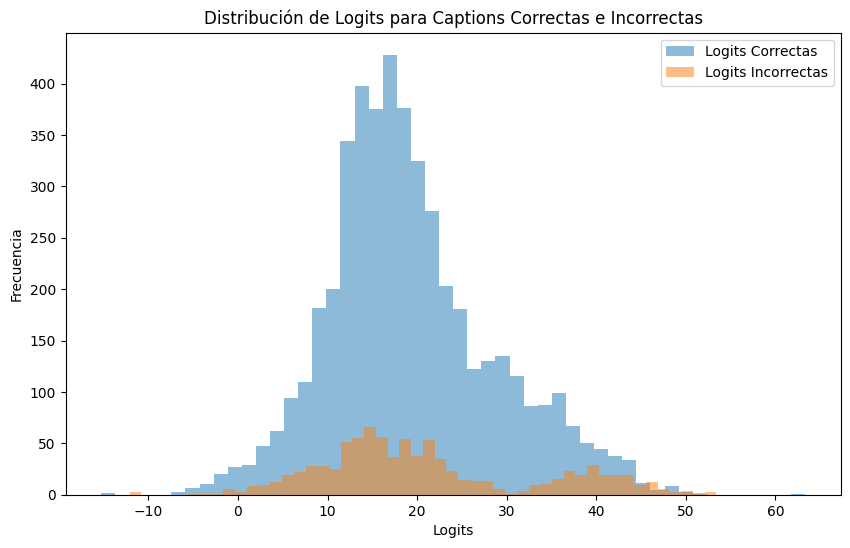

In [9]:
import matplotlib.pyplot as plt
import numpy as np

correct_probs = [item['sum_logP'] for item in datos_filtrados_log if item['acierto_log'] == 1]
incorrect_probs = [item['sum_logN'] for item in datos_filtrados_log if item['acierto_log'] == 0]


plt.figure(figsize=(10, 6))
plt.hist(correct_probs, bins=50, alpha=0.5, label='Logits Correctas')
plt.hist(incorrect_probs, bins=50, alpha=0.5, label='Logits Incorrectas')
plt.legend(loc='upper right')
plt.xlabel('Logits')
plt.ylabel('Frecuencia')
plt.title('Distribución de Logits para Captions Correctas e Incorrectas')
plt.show()

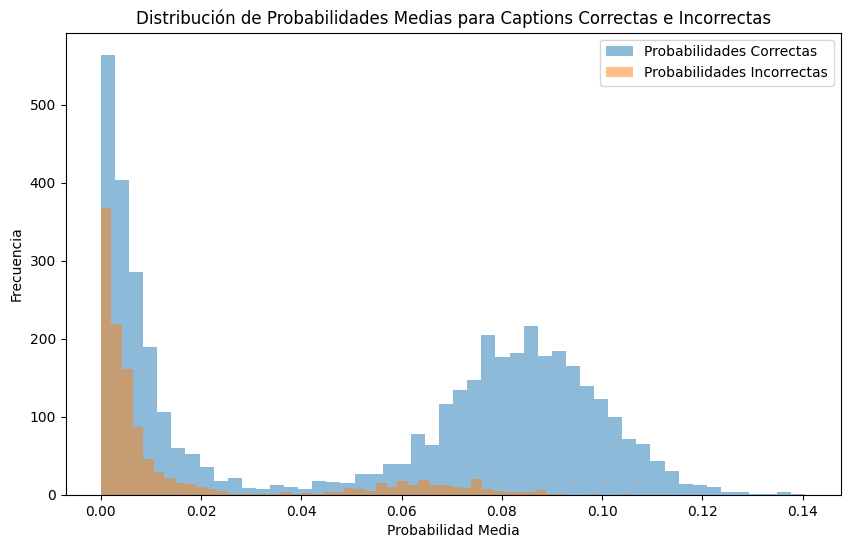

In [37]:

correct_probs = [diferencia_PN(item['mean_probP'],item['mean_probN']) for item in datos_filtrados_prob if item['acierto_prob'] == 1]
incorrect_probs = [diferencia_PN(item['mean_probP'],item['mean_probN']) for item in datos_filtrados_prob if item['acierto_prob'] == 0]


plt.figure(figsize=(10, 6))
plt.hist(correct_probs, bins=50, alpha=0.5, label='Probabilidades Correctas')
plt.hist(incorrect_probs, bins=50, alpha=0.5, label='Probabilidades Incorrectas')
plt.legend(loc='upper right')
plt.xlabel('Probabilidad Media')
plt.ylabel('Frecuencia')
plt.title('Distribución de Probabilidades Medias para Captions Correctas e Incorrectas')
plt.show()

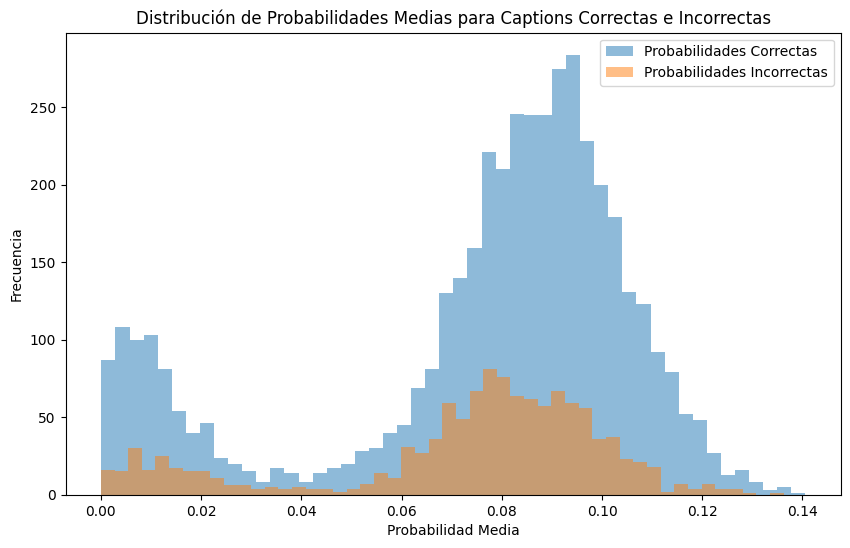

In [10]:
import matplotlib.pyplot as plt
import numpy as np

correct_probs = [item['mean_probP'] for item in datos_filtrados_prob if item['acierto_prob'] == 1]
incorrect_probs = [item['mean_probN'] for item in datos_filtrados_prob if item['acierto_prob'] == 0]


plt.figure(figsize=(10, 6))
plt.hist(correct_probs, bins=50, alpha=0.5, label='Probabilidades Correctas')
plt.hist(incorrect_probs, bins=50, alpha=0.5, label='Probabilidades Incorrectas')
plt.legend(loc='upper right')
plt.xlabel('Probabilidad Media')
plt.ylabel('Frecuencia')
plt.title('Distribución de Probabilidades Medias para Captions Correctas e Incorrectas')
plt.show()

In [52]:
import pandas as pd
df = pd.DataFrame(datos_filtrados_prob)

# Guardar el DataFrame en un archivo CSV
filename = 'datos_filtrados_prob.csv'
df.to_csv(filename, index=False)

In [53]:
df

,relacionE,acierto_prob,mean_probP,mean_probN
0,contains,1,0.087951,0.002292
1,at the left side of,0,0.101481,0.106294
2,ahead of,1,0.062004,0.000002
3,on,1,0.006575,0.000002
4,below,0,0.091110,0.092300
...,...,...,...,...
5616,below,0,0.076422,0.078981
5617,outside,0,0.072720,0.078842
5618,beneath,1,0.110610,0.000028
5619,touching,1,0.118482,0.018668


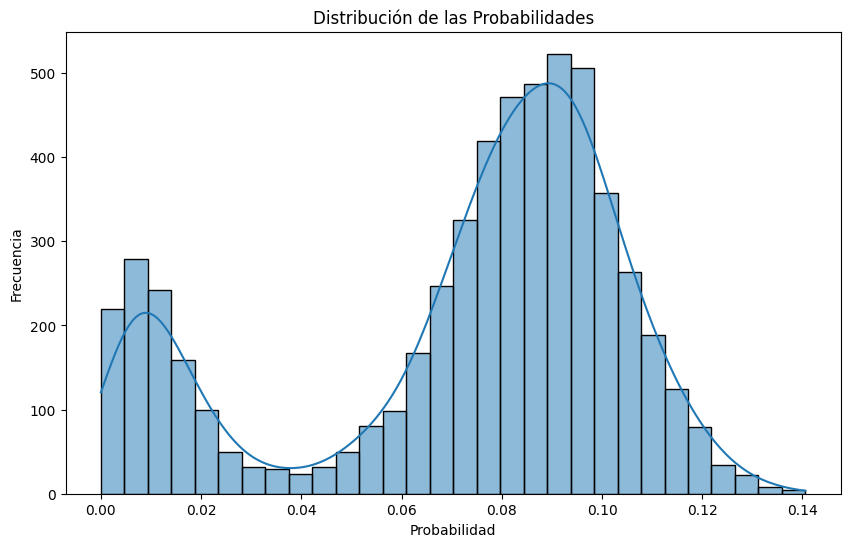

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma de dif_prob
plt.figure(figsize=(10, 6))
sns.histplot(df['mean_probP'], kde=True, bins=30)
plt.title('Distribución de las Probabilidades')
plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.show()

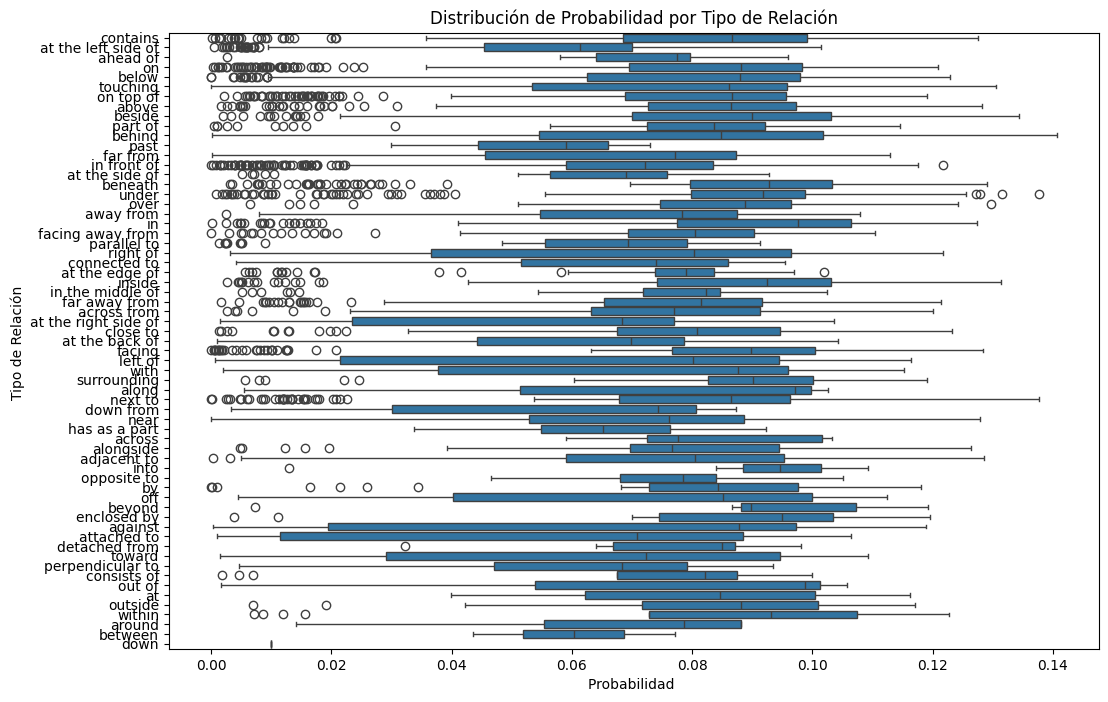

In [58]:
# Boxplot de dif_prob por tipo de relación
plt.figure(figsize=(12, 8))
sns.boxplot(x='mean_probP', y='relacionE', data=df)
plt.title('Distribución de Probabilidad por Tipo de Relación')
plt.xlabel('Probabilidad ')
plt.ylabel('Tipo de Relación ')
plt.show()

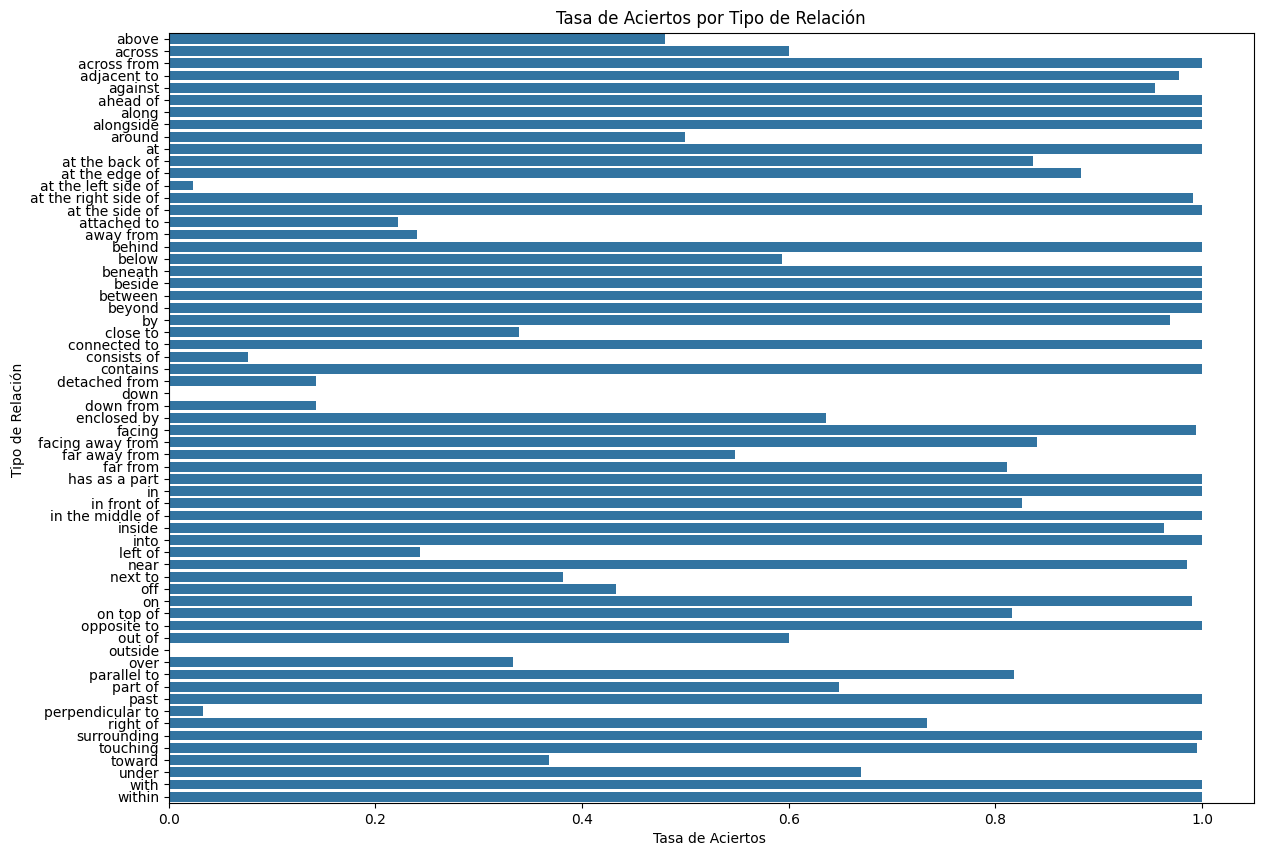

In [61]:
# Calcular la tasa de aciertos por tipo de relación
aciertos_por_relacion = df.groupby('relacionE')['acierto_prob'].mean().reset_index()

# Gráfico de barras de la tasa de aciertos por tipo de relación
plt.figure(figsize=(14, 10))
sns.barplot(x='acierto_prob', y='relacionE', data=aciertos_por_relacion)
plt.title('Tasa de Aciertos por Tipo de Relación')
plt.xlabel('Tasa de Aciertos ')
plt.ylabel('Tipo de Relación ')
plt.show()

<Axes: xlabel='mean_probP', ylabel='Density'>

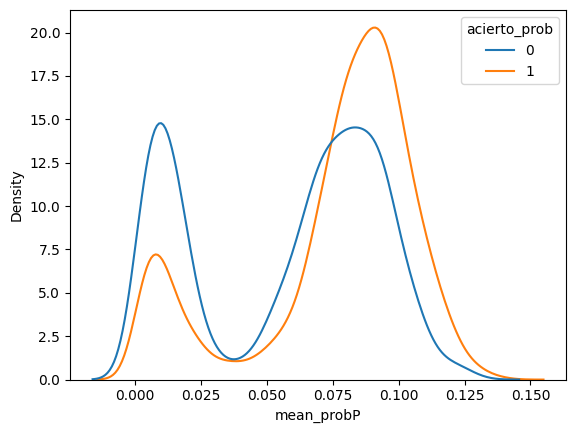

In [19]:
import pandas as pd
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(data=df, x="mean_probP", hue="acierto_prob", common_norm=False, bw_method=0.15)

<Axes: xlabel='mean_probP', ylabel='Density'>

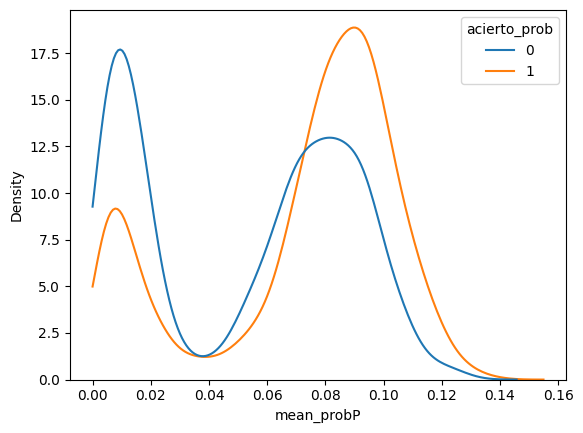

In [22]:
below0 = norm.cdf(x=0,loc=df['mean_probP'],scale=0.15)
above1 = 1- norm.cdf(x=1,loc=df['mean_probP'],scale=0.15)
df['edgeweight'] = 1/ (1 - below0 - above1)

sns.kdeplot(data=df, x="mean_probP", hue="acierto_prob", common_norm=False, bw_method=0.15, clip=(0,1), weights='edgeweight')

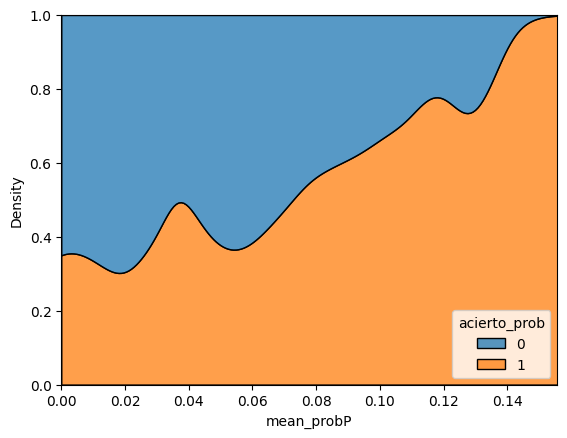

In [23]:
cum_plot = sns.kdeplot(data=df, x="mean_probP", hue="acierto_prob",
                       common_norm=False, bw_method=0.15,
                       clip=(0,1), weights='edgeweight',
                       multiple="fill", legend=True)
cum_plot.legend_._set_loc(4)

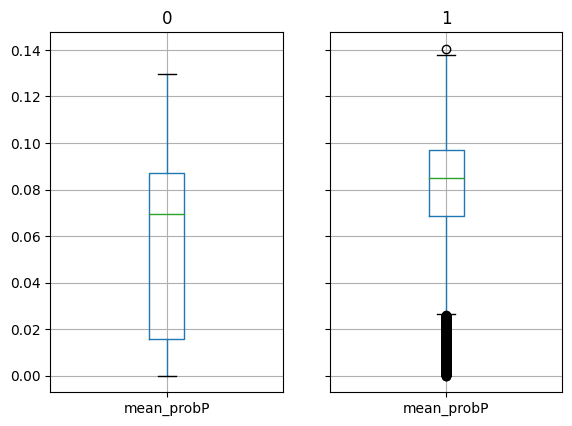

In [34]:
df.groupby("acierto_prob").boxplot(column="mean_probP");

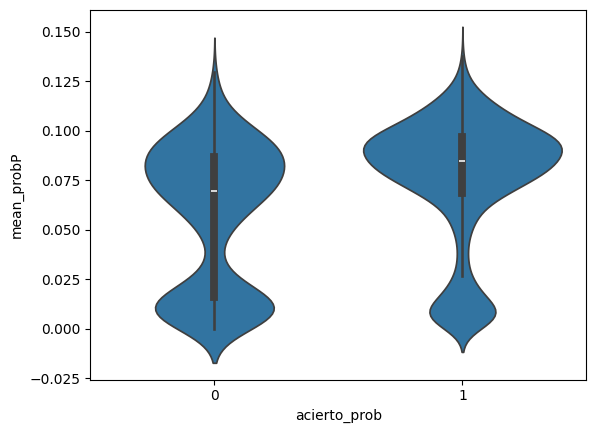

In [36]:
sns.violinplot(x="acierto_prob", y="mean_probP", data=df);

<ipython-input-31-30673dc172a1>:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  viol_sex = sns.violinplot(x="mean_probP", y="mean_probN", hue="acierto_prob",
<ipython-input-31-30673dc172a1>:4: FutureWarning: 

The `scale_hue` parameter has been replaced and will be removed in v0.15.0. Pass `common_norm=True` for the same effect.
  viol_sex = sns.violinplot(x="mean_probP", y="mean_probN", hue="acierto_prob",
<ipython-input-31-30673dc172a1>:4: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.15`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  viol_sex = sns.violinplot(x="mean_probP", y="mean_probN", hue="acierto_prob",


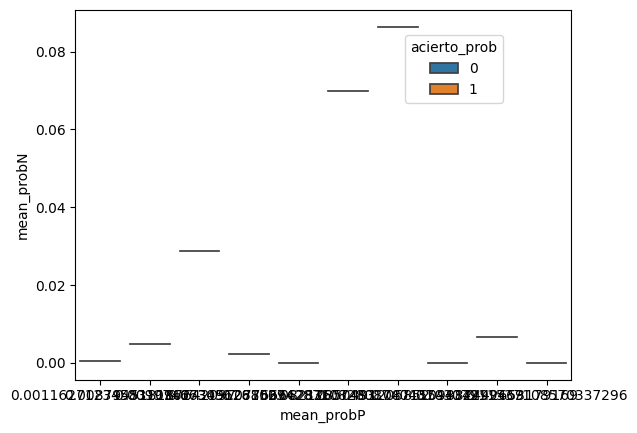

In [31]:
n = 10 #larger n will result in more accurate KDE
resamp_pp = df.sample(n=n,replace=True, weights='edgeweight',random_state=10)

viol_sex = sns.violinplot(x="mean_probP", y="mean_probN", hue="acierto_prob",
                          data=resamp_pp, split=True, cut=0,
                          bw=0.15, inner=None,
                          scale='count', scale_hue=False)
viol_sex.legend_.set_bbox_to_anchor((0.65, 0.95))